For each weather data 
- Save the raw data to parquet file
- Union extended data w previous data
- Join w veg data to reduce # of grids
- Exclude desert regions, agricultural lands, and urban areas based on the vegetation type data.
  - mod_data = mod_data[~mod_data['veg'].str.contains('Water|Urban|Agriculture')]

In [97]:
# Force garbage collection
import gc
gc.collect()

6484

In [98]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import pyproj
from tqdm import tqdm
import numpy as np

In [167]:
from datetime import datetime

In [99]:
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [100]:
# check python version and all packages version
def check_python_version():
    import sys
    print("Python version")
    print (sys.version)
    print("Pandas version")
    print(pd.__version__)
    print("Geopandas version")
    print(gpd.__version__)
    print("Xarray version")
    print(xr.__version__)
    print("Pyproj version")
    print(pyproj.__version__)

check_python_version()

Python version
3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]
Pandas version
2.2.2
Geopandas version
0.14.2
Xarray version
2023.6.0
Pyproj version
3.6.1


In [101]:
pd.set_option('display.max_colwidth', None)

In [102]:
files = os.listdir('../../Extended_Data/Weather/')
files

['dead_fuel_moisture_1000h.1994.2000.CA.nc',
 'dead_fuel_moisture_100h.1994.2000.CA.nc',
 'max_air_temperature.1994.2000.CA.nc',
 'max_relative_humidity.1994.2000.CA.nc',
 'min_air_temperature.1994.2000.CA.nc',
 'min_relative_humidity.1994.2000.CA.nc',
 'pdsi.CA.nc',
 'precipitation_amount.1994.2000.CA.nc',
 'specific_humidity.1994.2000.CA.nc',
 'spei.CA.nc',
 'surface_downwelling_shortwave_flux.1994.2000.CA.nc',
 'vapor_pressure_deficit.1994.2000.CA.nc',
 'wind_from_direction.1994.2000.CA.nc',
 'wind_speed.1994.2000.CA.nc']

In [103]:
# drop vapor_pressure_deficit.1994.2000.CA.nc from files
files = [f for f in files if 'vapor_pressure_deficit.1994.2000.CA.nc' not in f]
files = [f for f in files if 'pdsi.CA.nc' not in f]
files = [f for f in files if 'spei.CA.nc' not in f]
files

['dead_fuel_moisture_1000h.1994.2000.CA.nc',
 'dead_fuel_moisture_100h.1994.2000.CA.nc',
 'max_air_temperature.1994.2000.CA.nc',
 'max_relative_humidity.1994.2000.CA.nc',
 'min_air_temperature.1994.2000.CA.nc',
 'min_relative_humidity.1994.2000.CA.nc',
 'precipitation_amount.1994.2000.CA.nc',
 'specific_humidity.1994.2000.CA.nc',
 'surface_downwelling_shortwave_flux.1994.2000.CA.nc',
 'wind_from_direction.1994.2000.CA.nc',
 'wind_speed.1994.2000.CA.nc']

In [104]:
data_dir = '../../Extended_Data/Weather/'

In [105]:
for file in files:
    # print separator
    print("\n" + "="*40 + "\n")
    ds = xr.open_dataset(os.path.join(data_dir, file))
    print(f"File: {file}")
    print(f"Dimensions: {ds.dims}")
    # print the min and max of coordinates day
    if 'day' in ds.coords:
        print(f"Day range: {ds.coords['day'].min().values} to {ds.coords['day'].max().values}")
    else:
        print("Day coordinate not found.")
    print(f"Coordinates: {ds.coords}")
    print(f"Data variables: {ds.data_vars}")



File: dead_fuel_moisture_1000h.1994.2000.CA.nc
Dimensions: Frozen({'lon': 258, 'lat': 238, 'day': 2557, 'crs': 1})
Day range: 1994-01-01T00:00:00.000000000 to 2000-12-31T00:00:00.000000000
Coordinates: Coordinates:
  * lon      (lon) float64 -124.7 -124.6 -124.6 -124.6 ... -114.1 -114.0 -114.0
  * lat      (lat) float64 42.19 42.15 42.11 42.07 ... 32.44 32.4 32.36 32.32
  * day      (day) datetime64[ns] 1994-01-01 1994-01-02 ... 2000-12-31
  * crs      (crs) uint16 3
    year     (day) int32 ...
Data variables: Data variables:
    dead_fuel_moisture_1000hr  (day, lat, lon) float32 ...


File: dead_fuel_moisture_100h.1994.2000.CA.nc
Dimensions: Frozen({'lon': 258, 'lat': 238, 'day': 2557, 'crs': 1})
Day range: 1994-01-01T00:00:00.000000000 to 2000-12-31T00:00:00.000000000
Coordinates: Coordinates:
  * lon      (lon) float64 -124.7 -124.6 -124.6 -124.6 ... -114.1 -114.0 -114.0
  * lat      (lat) float64 42.19 42.15 42.11 42.07 ... 32.44 32.4 32.36 32.32
  * day      (day) datetime64[ns

In [106]:
# Function to check if dimensions and coordinates match
def check_compatibility(ds1, ds2):
    return ds1.dims == ds2.dims and all(ds1.coords[dim].equals(ds2.coords[dim]) for dim in ds1.dims)

compatible_files = []

# Load the reference dataset
reference_file = files[0]
reference_ds = xr.open_dataset(os.path.join(data_dir, reference_file))
compatible_files.append(reference_file)

# Iterate over the remaining files and check compatibility
for file in files[1:]:
    file_name = file.split('.')[0]
    ds = xr.open_dataset(os.path.join(data_dir, file))
    if check_compatibility(reference_ds, ds):
        compatible_files.append(file)
    else:
        print(f"Dimensions or coordinates do not match for file: {file}")

In [107]:
compatible_files

['dead_fuel_moisture_1000h.1994.2000.CA.nc',
 'dead_fuel_moisture_100h.1994.2000.CA.nc',
 'max_air_temperature.1994.2000.CA.nc',
 'max_relative_humidity.1994.2000.CA.nc',
 'min_air_temperature.1994.2000.CA.nc',
 'min_relative_humidity.1994.2000.CA.nc',
 'precipitation_amount.1994.2000.CA.nc',
 'specific_humidity.1994.2000.CA.nc',
 'surface_downwelling_shortwave_flux.1994.2000.CA.nc',
 'wind_from_direction.1994.2000.CA.nc',
 'wind_speed.1994.2000.CA.nc']

In [ ]:
path_to_save = '../../Clean_Data/Weather_Data/Extended_Weather_Data/'
# Ensure the output directory exists
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)
    
for file in compatible_files:
    ds = xr.open_dataset(os.path.join(data_dir, file))
    
    # Convert the dataset to a pandas DataFrame
    panda_df = ds.to_dataframe().reset_index()
    
    # if check col crs only have 1 unique value, if so, drop it
    if 'crs' in panda_df.columns and panda_df['crs'].nunique() == 1:
        panda_df = panda_df.drop(columns=['crs'])
        
    # Save the DataFrame as a Parquet file
    output_file = f'{path_to_save}/{file.split(".")[0]}.parquet'
    panda_df.to_parquet(output_file)
    
    # Print the action
    print(f"Saved {file} as {output_file}")

    # clean up
    del ds
    gc.collect()

In [ ]:
path1 = '../../Clean_Data/Weather_Data/Extended_Weather_Data/'
path2 = '../../Clean_Data/Weather_Data/'

path_to_save = '../../Clean_Data/Weather_Data/Combined_Weather_Data/'
# Ensure the output directory exists
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)

missing_rate_dict = {}

for file in tqdm(os.listdir(path1)):

    dat1 = pd.read_parquet(f'{path1}/{file}')
    if file == 'dead_fuel_moisture_100h.parquet':
        file_name_for_dat2 = 'dead_fuel_moisture_100hr.parquet'
    elif file == 'dead_fuel_moisture_1000h.parquet':
        file_name_for_dat2 = 'dead_fuel_moisture_1000hr.parquet'
    else:
        file_name_for_dat2 = file
    dat2 = pd.read_parquet(f'{path2}/{file_name_for_dat2}')

    # add year column based on the 'day' column in dat2
    dat2['year'] = dat2['day'].dt.year

    cols_in_dat2 = dat2.columns
    dat1 = dat1[cols_in_dat2]

    # union the two DataFrames
    combined_df = pd.concat([dat1, dat2], ignore_index=True)

    # Rename columns based on conditions
    if 'air_temperature' in combined_df.columns:
        if 'max' in file:
            combined_df.rename(columns={'air_temperature': 'max_air_temperature'}, inplace=True)
        elif 'min' in file:
            combined_df.rename(columns={'air_temperature': 'min_air_temperature'}, inplace=True)
    
    if 'relative_humidity' in combined_df.columns:
        if 'max' in file:
            combined_df.rename(columns={'relative_humidity': 'max_relative_humidity'}, inplace=True)
        elif 'min' in file:
            combined_df.rename(columns={'relative_humidity': 'min_relative_humidity'}, inplace=True)
    
    # get column name in 4th column
    weather_variable = combined_df.columns[3]
    # group by 'year', calculate the missing rate for weather_variable
    missing_rate_by_year = combined_df.groupby('year')[weather_variable].apply(lambda x: x.isnull().mean())

    # Store missing rates in the dictionary
    for year, rate in missing_rate_by_year.items():
        if year not in missing_rate_dict:
            missing_rate_dict[year] = {}
        missing_rate_dict[year][weather_variable] = rate

    # Save the combined DataFrame as a Parquet file
    combined_df.to_parquet(f'{path_to_save}/{file}')

    # clean up
    del dat1, dat2, combined_df
    gc.collect()

100%|██████████| 11/11 [29:44<00:00, 162.18s/it]


In [ ]:
# Convert the dictionary to a DataFrame
missing_rate_df = pd.DataFrame.from_dict(missing_rate_dict, orient='index').sort_index()
missing_rate_df.index.name = 'year'

In [ ]:
missing_rate_df

dead_fuel_moisture_1000hr  dead_fuel_moisture_100hr  \
year                                                        
1994                   0.599554                  0.599554   
1995                   0.599554                  0.599554   
1996                   0.599554                  0.599554   
1997                   0.599554                  0.599554   
1998                   0.599554                  0.599554   
1999                   0.599554                  0.599554   
2000                   0.599554                  0.599554   
2001                   0.602928                  0.602928   
2002                   0.602928                  0.602928   
2003                   0.602928                  0.602928   
2004                   0.602928                  0.602928   
2005                   0.602928                  0.602928   
2006                   0.602928                  0.602928   
2007                   0.602928                  0.602928   
2008                   0.602928                  0.602928   
2009                   0.602928                  0.602928   
2010                   0.602928                  0.602928   
2011                   0.602928                  0.602928   
2012                   0.602928                  0.602928   
2013                   0.602928                  0.602928   
2014                   0.602928                  0.602928   
2015                   0.602928                  0.602928   
2016                   0.602928                  0.602928   
2017                   0.602928                  0.602928   
2018                   0.602928                  0.602928   
2019                   0.602928                  0.602928   
2020                   0.602928                  0.602928   
2021                   0.602928                  0.602928   
2022                   0.602928                  0.602928   
2023                   0.602928                  0.602928   

      max_air_temperature  max_relative_humidity  min_air_temperature  \
year                                                                    
1994             0.599554               0.599554             0.599554   
1995             0.599554               0.599554             0.599554   
1996             0.599554               0.599554             0.599554   
1997             0.599554               0.599554             0.599554   
1998             0.599554               0.599554             0.599554   
1999             0.599554               0.599554             0.599554   
2000             0.599554               0.599554             0.599554   
2001             0.004376               0.602928             0.004376   
2002             0.004376               0.602928             0.004376   
2003             0.004376               0.602928             0.004376   
2004             0.004376               0.602928             0.004376   
2005             0.004376               0.602928             0.004376   
2006             0.004376               0.602928             0.004376   
2007             0.004376               0.602928             0.004376   
2008             0.004376               0.602928             0.004376   
2009             0.004376               0.602928             0.004376   
2010             0.004376               0.602928             0.004376   
2011             0.004376               0.602928             0.004376   
2012             0.004376               0.602928             0.004376   
2013             0.004376               0.602928             0.004376   
2014             0.004376               0.602928             0.004376   
2015             0.004376               0.602928             0.004376   
2016             0.004376               0.602928             0.004376   
2017             0.004376               0.602928             0.004376   
2018             0.004376               0.602928             0.004376   
2019             0.004376               0.602928             0.004376   
2020     

In [ ]:
path_to_save = '../../Summary_Data/Missing_Rate/'
# Ensure the output directory exists
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)
# Save to CSV or parquet if needed
missing_rate_df.to_csv(os.path.join(path_to_save, 'raw_weather_data.csv'))

Plot to investigate the missing rate

after investigation, 

- for air max_air_temperature, data after 2000 have lower missing rate bc it include 0. after removing 0, the missing rate across years back to normal
- for precipitation_amount, data after 2000 have higher missing rate bc it exclude 0. after removing 0 for extended data, the missing rate across years back to normal

In [ ]:
import matplotlib.pyplot as plt

In [155]:
path_to_read = '../../Clean_Data/Weather_Data/Combined_Weather_Data/'
max_air_temperature_dat = pd.read_parquet(f'{path_to_read}/max_air_temperature.parquet')
# when it is 0, assign it to np.nan
max_air_temperature_dat['max_air_temperature'] = max_air_temperature_dat['max_air_temperature'].replace(0, np.nan)

In [156]:
max_air_temperature_dat.groupby('year')['max_air_temperature'].apply(lambda x: x.isnull().mean())

year
1994    0.599554
1995    0.599554
1996    0.599554
1997    0.599554
1998    0.599554
1999    0.599554
2000    0.599554
2001    0.602928
2002    0.602928
2003    0.602928
2004    0.602928
2005    0.602928
2006    0.602928
2007    0.602928
2008    0.602928
2009    0.602928
2010    0.602928
2011    0.602928
2012    0.602928
2013    0.602928
2014    0.602928
2015    0.602928
2016    0.602928
2017    0.602928
2018    0.602928
2019    0.602928
2020    0.602928
2021    0.602928
2022    0.602928
2023    0.602928
Name: max_air_temperature, dtype: float64

In [150]:
# Filter data for the two dates
dat_1998 = max_air_temperature_dat[max_air_temperature_dat['day'] == '1998-01-01']
dat_2009 = max_air_temperature_dat[max_air_temperature_dat['day'] == '2009-01-01']

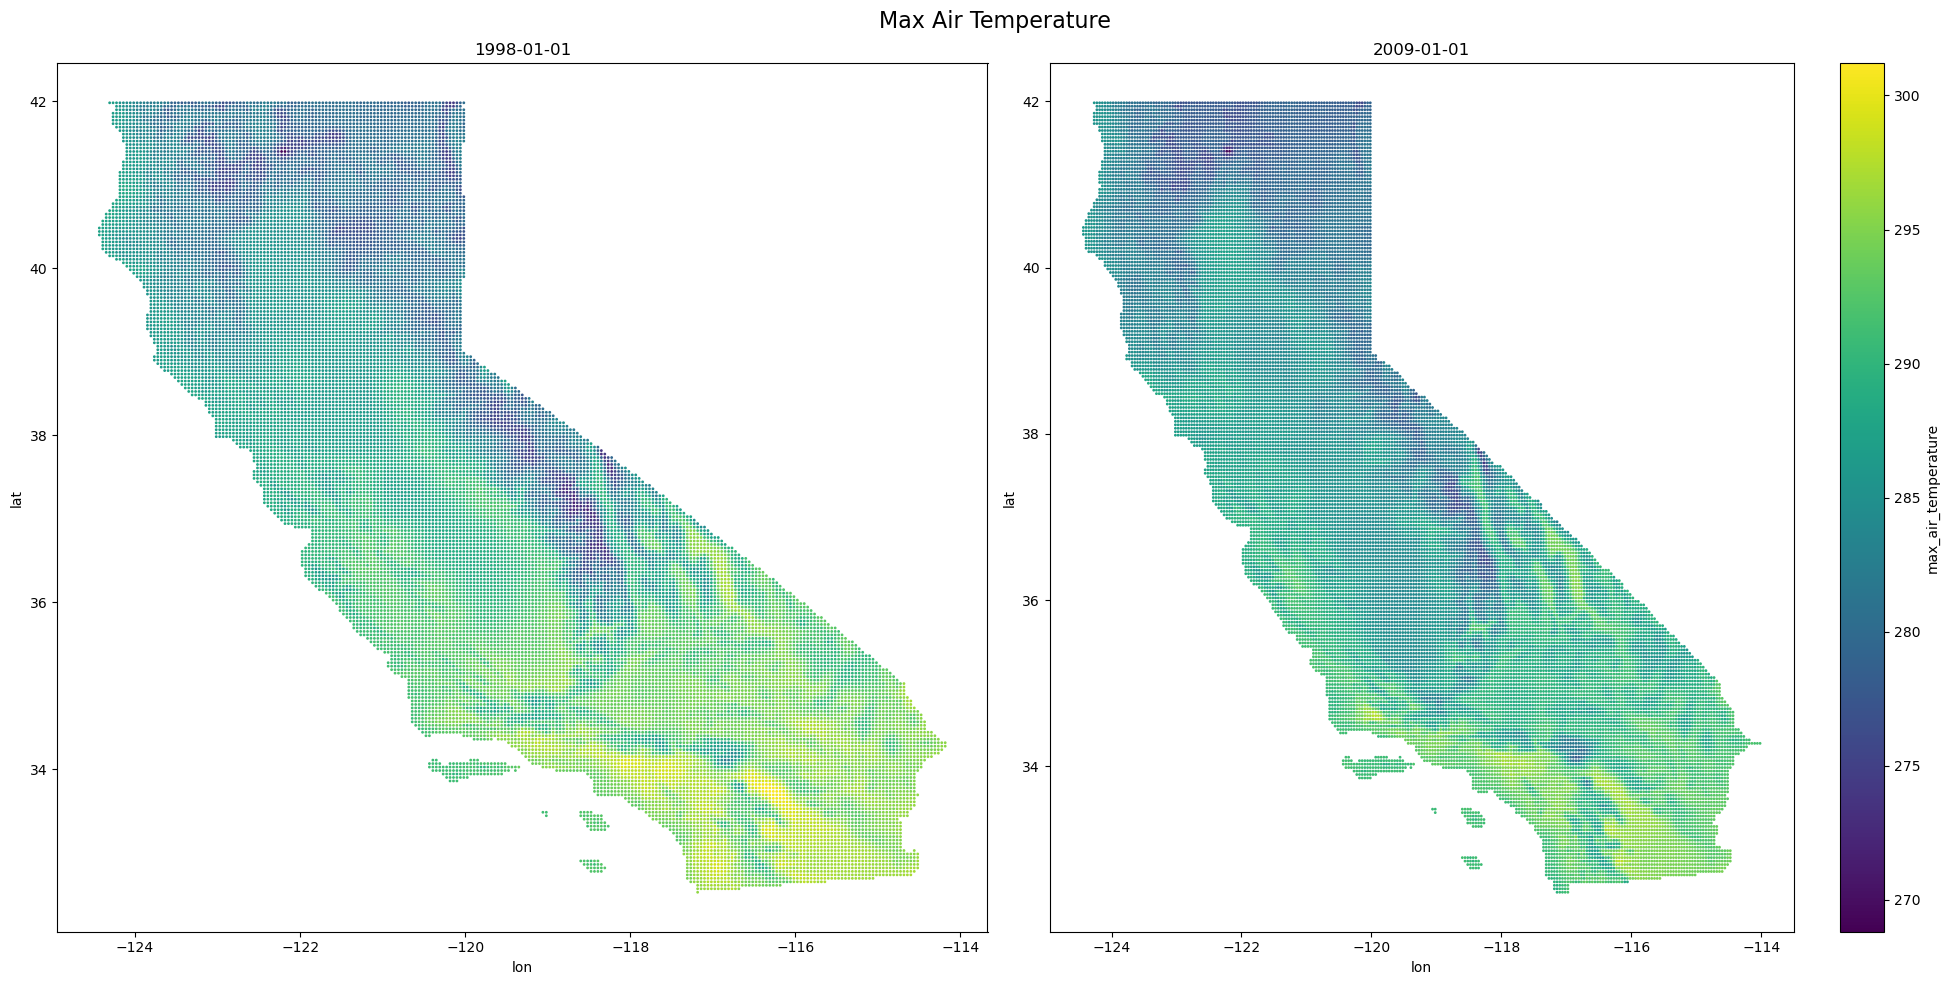

In [151]:
vmin = min(dat_1998['max_air_temperature'].min(), dat_2009['max_air_temperature'].min())
vmax = max(dat_1998['max_air_temperature'].max(), dat_2009['max_air_temperature'].max())

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

dat_1998.plot(
    kind='scatter',
    x='lon',
    y='lat',
    c='max_air_temperature',
    cmap='viridis',
    s=1,
    ax=axes[0],
    colorbar=False,
    vmin=vmin,
    vmax=vmax
)
axes[0].set_title('1998-01-01')

sc = dat_2009.plot(
    kind='scatter',
    x='lon',
    y='lat',
    c='max_air_temperature',
    cmap='viridis',
    s=1,
    ax=axes[1],
    colorbar=True,
    vmin=vmin,
    vmax=vmax
)
axes[1].set_title('2009-01-01')

plt.suptitle('Max Air Temperature', fontsize=16)
plt.tight_layout()
plt.show()
plt.close()

In [154]:
gc.collect()
del max_air_temperature_dat, dat_1998, dat_2009, fig, axes, sc

In [135]:
rain_dat = pd.read_parquet(f'{path_to_read}/precipitation_amount.parquet')

In [136]:
rain_dat = rain_dat[rain_dat['precipitation_amount'] != 0]
rain_dat.groupby('year')['precipitation_amount'].apply(lambda x: x.isnull().mean())

year
1994    0.866132
1995    0.846421
1996    0.848896
1997    0.870008
1998    0.807919
1999    0.874323
2000    0.868701
2001    0.916766
2002    0.942734
2003    0.916357
2004    0.929357
2005    0.908471
2006    0.912473
2007    0.937350
2008    0.937784
2009    0.934598
2010    0.919427
2011    0.930437
2012    0.933082
2013    0.957305
2014    0.945744
2015    0.941770
2016    0.924137
2017    0.925220
2018    0.938591
2019    0.912163
2020    0.946733
2021    0.934854
2022    0.947258
2023    0.917471
Name: precipitation_amount, dtype: float64

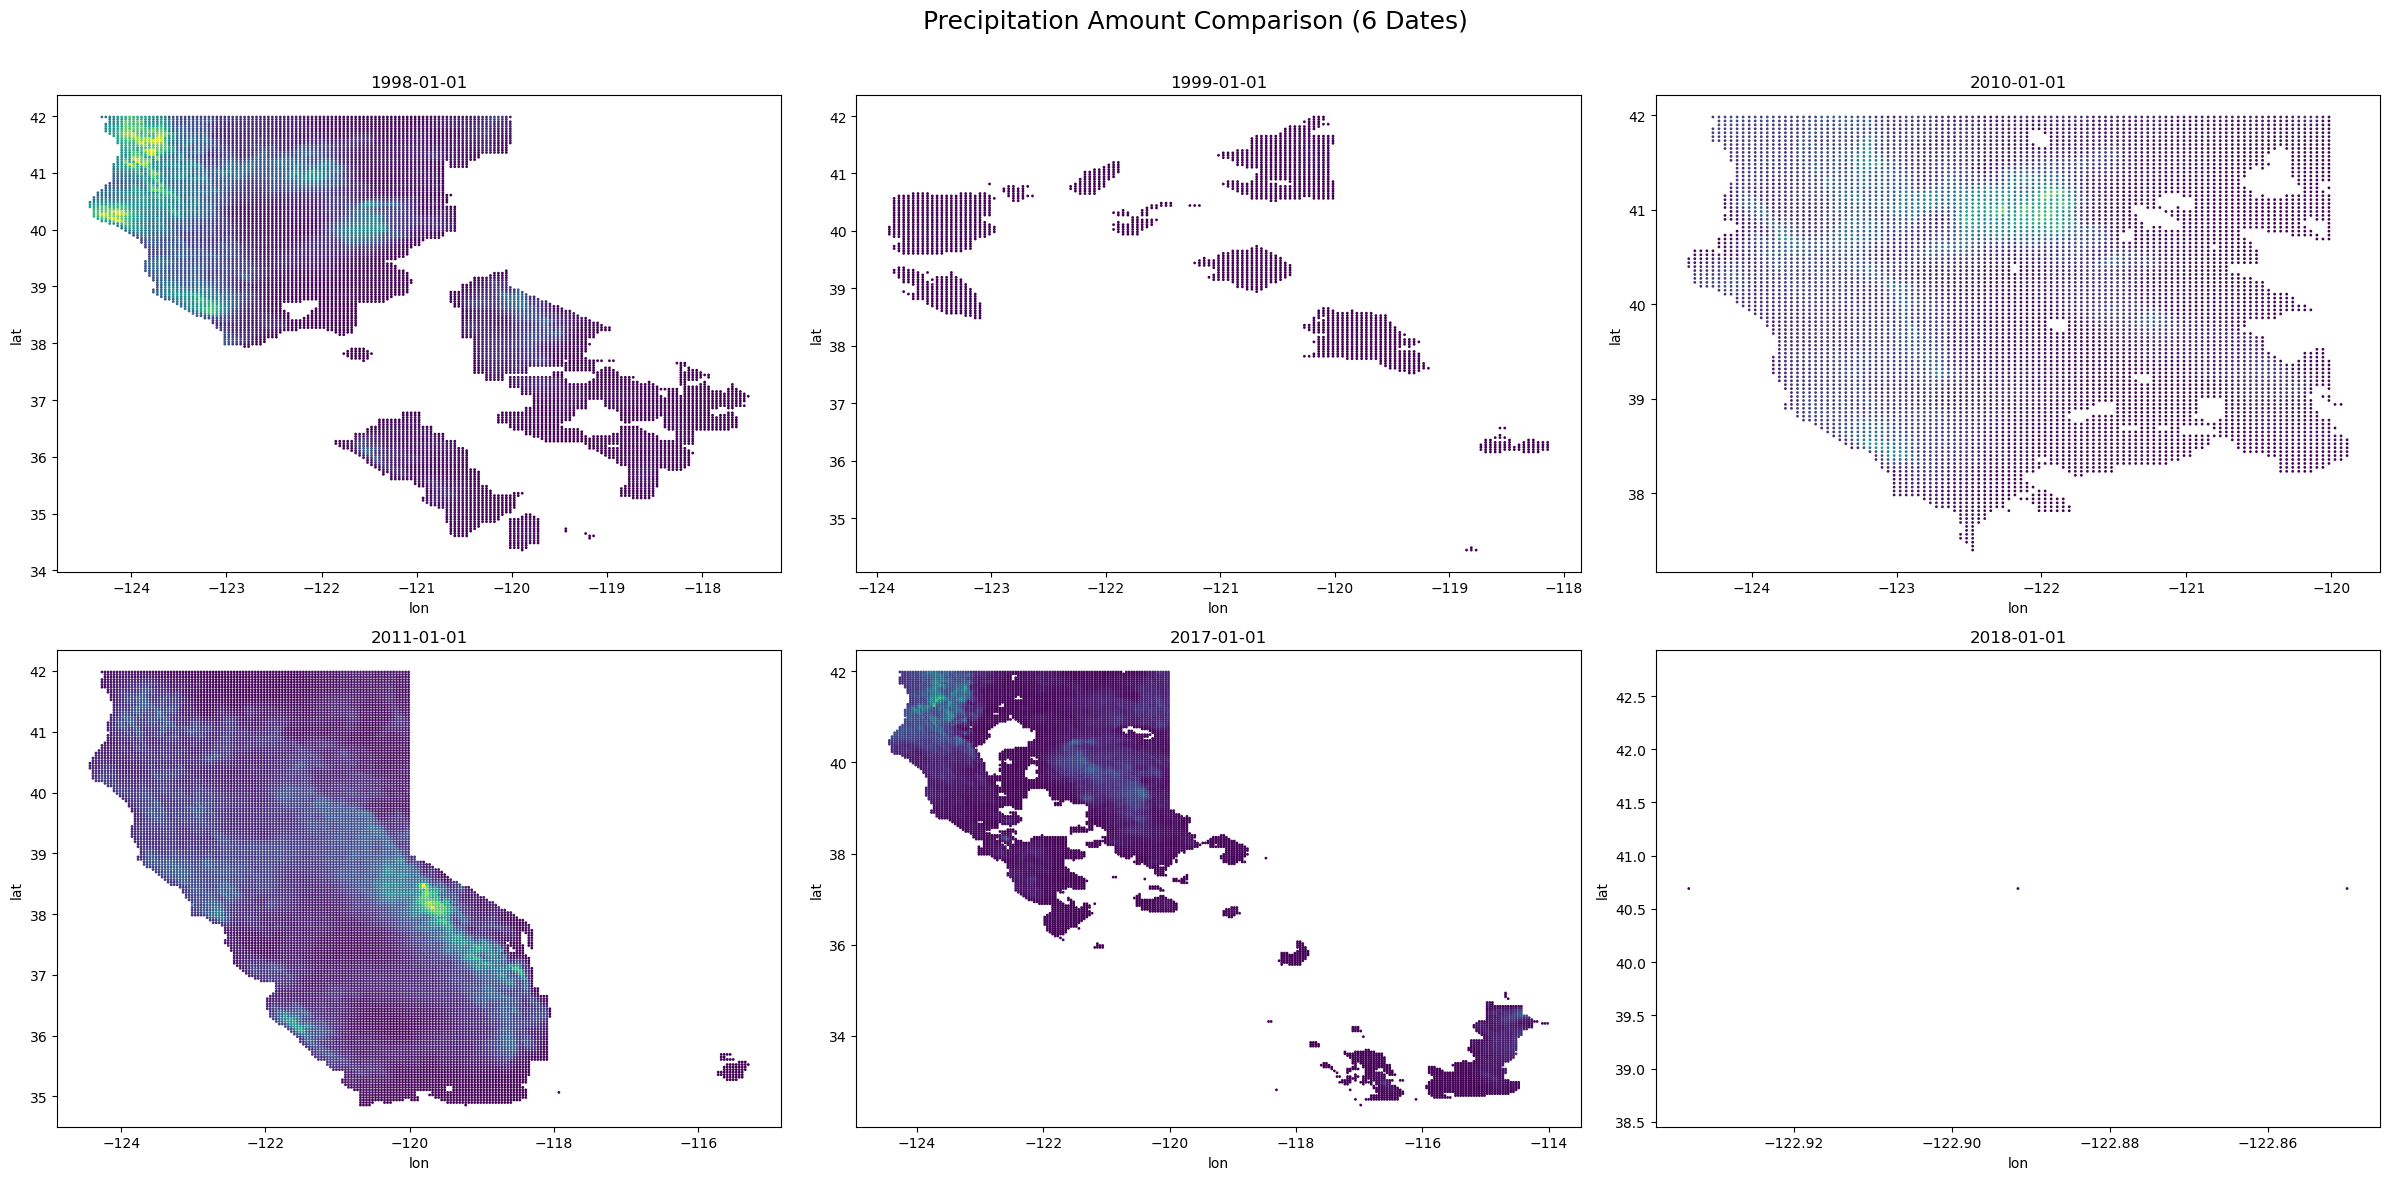

In [ ]:
dates = ['1998-01-01', '1999-01-01', '2010-01-01', '2011-01-01', '2017-01-01', '2018-01-01']
titles = dates
data_list = [rain_dat[rain_dat['day'] == d] for d in dates]
data_list = [df[df['precipitation_amount'] != 0] for df in data_list]

vmin = min(df['precipitation_amount'].min() for df in data_list)
vmax = max(df['precipitation_amount'].max() for df in data_list)

#fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig, axes = plt.subplots(2, 3, figsize=(24, 12))
axes = axes.flatten()

for i, ax in enumerate(axes):
    data_list[i].plot(
        kind='scatter',
        x='lon',
        y='lat',
        c='precipitation_amount',
        cmap='viridis',
        s=1,
        ax=ax,
        colorbar=False,
        vmin=vmin,
        vmax=vmax
    )
    ax.set_title(titles[i])

plt.suptitle('Precipitation Amount Comparison (6 Dates)', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
plt.close()

In [140]:
del rain_dat, fig, axes
gc.collect()

14360

## Merge w Veg Data

In [157]:
# clean up memory
gc.collect()
# delete all dataframes
for var in list(globals().keys()):
    if isinstance(globals()[var], pd.DataFrame):
        del globals()[var]

In [159]:
# the data is generated from 02 Veg Data Extract.ipynb
veg_data = pd.read_parquet('../../Clean_Data/lon_lat_pair_weather_match_veg_v2.parquet')

In [160]:
veg_data.shape

(17703, 7)

In [161]:
veg_data.head()

lon        lat  type  distance                   veg_type_details  \
0 -124.391667  40.441667   7.0  1.826642   Native Coastal Sage Scrub - fire   
1 -124.391667  40.400000  25.0  1.827314         Native Oak Woodland - fire   
2 -124.350000  40.566667   1.0  1.824622                  Agriculture - low   
3 -124.350000  40.525000   8.0  1.825296  Native Coastal Sage Scrub - mesic   
4 -124.350000  40.483333  25.0  1.825969         Native Oak Woodland - fire   

  fire_attribute                         veg  
0           fire  Native Coastal Sage Scrub   
1           fire        Native Oak Woodland   
2            low                Agriculture   
3          mesic  Native Coastal Sage Scrub   
4           fire        Native Oak Woodland

In [ ]:
veg_data[['lon', 'lat']].duplicated().sum()

0

In [162]:
veg_data_filter = veg_data[~veg_data['veg'].str.contains('Water|Urban|Agriculture')]

In [163]:
veg_data_filter.shape

(14383, 7)

In [165]:
veg_data_filter.head()

lon        lat  type  distance                   veg_type_details  \
0 -124.391667  40.441667   7.0  1.826642   Native Coastal Sage Scrub - fire   
1 -124.391667  40.400000  25.0  1.827314         Native Oak Woodland - fire   
3 -124.350000  40.525000   8.0  1.825296  Native Coastal Sage Scrub - mesic   
4 -124.350000  40.483333  25.0  1.825969         Native Oak Woodland - fire   
5 -124.350000  40.441667  10.0  1.826642        Native Conifer Alpine - low   

  fire_attribute                         veg  
0           fire  Native Coastal Sage Scrub   
1           fire        Native Oak Woodland   
3          mesic  Native Coastal Sage Scrub   
4           fire        Native Oak Woodland   
5            low      Native Conifer Alpine

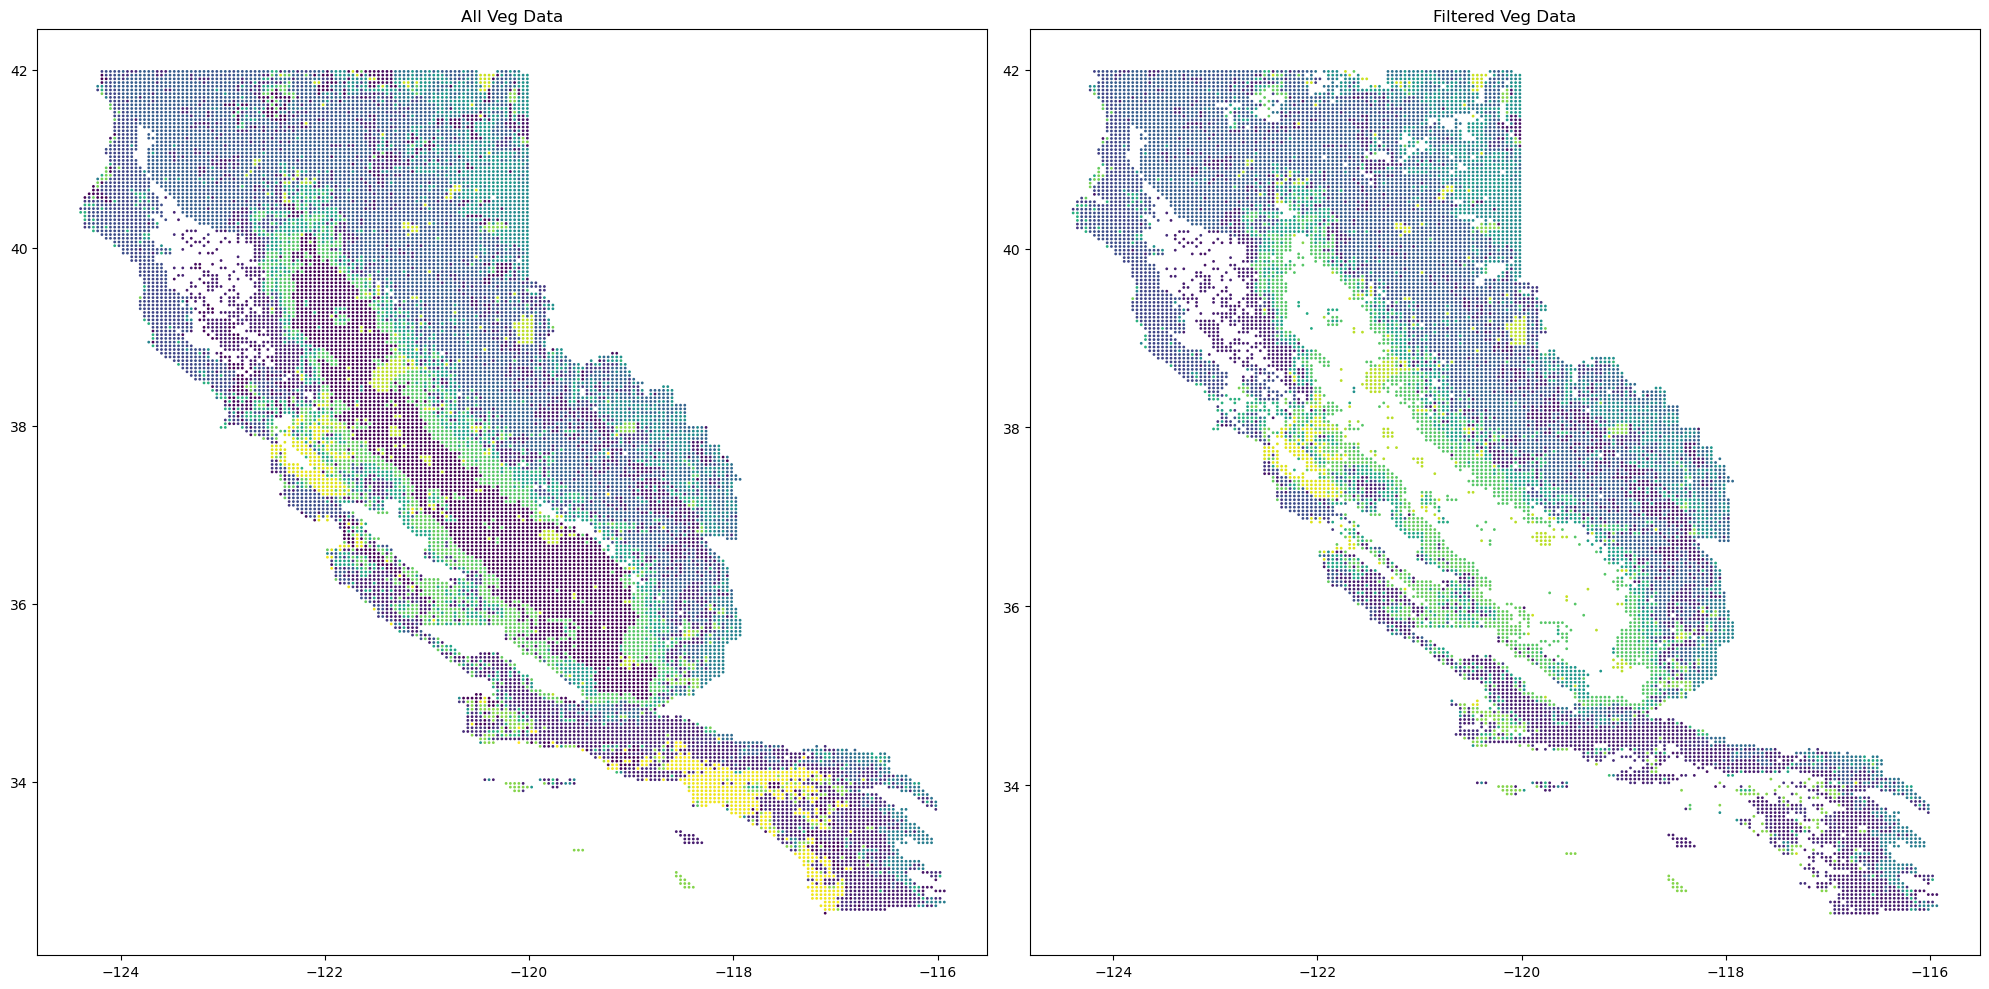

In [164]:
vmin = min(veg_data['type'].min(), veg_data_filter['type'].min())
vmax = max(veg_data['type'].max(), veg_data_filter['type'].max())

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

sc1 = axes[0].scatter(
    veg_data['lon'], veg_data['lat'],
    c=veg_data['type'], cmap='viridis', s=1, vmin=vmin, vmax=vmax
)
axes[0].set_title('All Veg Data')

sc2 = axes[1].scatter(
    veg_data_filter['lon'], veg_data_filter['lat'],
    c=veg_data_filter['type'], cmap='viridis', s=1, vmin=vmin, vmax=vmax
)
axes[1].set_title('Filtered Veg Data')

# Add a shared colorbar
#cbar = fig.colorbar(sc2, ax=axes, orientation='vertical', fraction=0.03, pad=0.04)
#cbar.set_label('Type')

plt.tight_layout()
plt.show()
plt.close()

In [166]:
# veg_data.plot(kind='scatter', x='lon', y='lat', c='type', cmap='viridis', s=1, figsize=(10, 10))
# plt.show()
# plt.close()

In [168]:
path_to_read = '../../Clean_Data/Weather_Data/Combined_Weather_Data/'
path_to_save = '../../Clean_Data/Weather_Data/Combined_Weather_Data_w_Veg_Filter/'
# Ensure the output directory exists
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)

missing_rate_dict = {}
log_messages = []
log_messages.append("Task: Data cleaning on extended weather data with vegetation filter")
log_messages.append(f"Processing started on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

for file in tqdm(os.listdir(path_to_read)):
    # add separator for each file processing
    print("\n" + "="*40 + "\n")
    dat = pd.read_parquet(f'{path_to_read}/{file}')
    # add shape to log messages
    log_messages.append(f"Processing file: {file}, shape: {dat.shape}")
    # merge it with veg_data to filter the DataFrame
    dat_filtered = pd.merge(dat, veg_data_filter[['lon', 'lat']], on=['lon', 'lat'], how='inner')
    # add shape to log messages
    log_messages.append(f"Filtered DataFrame shape: {dat_filtered.shape}")
    
    # Save the filtered DataFrame as a Parquet file
    dat_filtered.to_parquet(f'{path_to_save}/{file}')

    # clean up
    del dat, dat_filtered
    gc.collect()

  0%|          | 0/11 [00:00<?, ?it/s]

  9%|▉         | 1/11 [02:38<26:25, 158.57s/it]

 18%|█▊        | 2/11 [05:11<23:18, 155.38s/it]

 27%|██▋       | 3/11 [07:52<21:04, 158.06s/it]

 36%|███▋      | 4/11 [10:17<17:48, 152.63s/it]

 45%|████▌     | 5/11 [12:58<15:33, 155.57s/it]

 55%|█████▍    | 6/11 [15:29<12:50, 154.14s/it]

 64%|██████▎   | 7/11 [25:43<20:17, 304.37s/it]

 73%|███████▎  | 8/11 [28:20<12:52, 257.46s/it]

 82%|████████▏ | 9/11 [31:10<07:40, 230.31s/it]

 91%|█████████ | 10/11 [33:36<03:24, 204.20s/it]

100%|██████████| 11/11 [36:05<00:00, 196.90s/it]


In [170]:
log_save_path = '../../Logs/Clean_Extended_Data/'
# Ensure the log directory exists
if not os.path.exists(log_save_path):
    os.makedirs(log_save_path)
with open(f'{log_save_path}/clean_weather_data_log.txt', 'w') as log_file:
    log_file.write('\n'.join(log_messages))